In [1]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

### 1. Load dataset

In [2]:
train_image_dir = "data/train/image"
train_mask_dir = "data/train/mask"
val_image_dir = "data/val/image"
val_mask_dir = "data/val/mask"
test_image_dir = "data/test/image"
test_mask_dir = "data/test/mask"

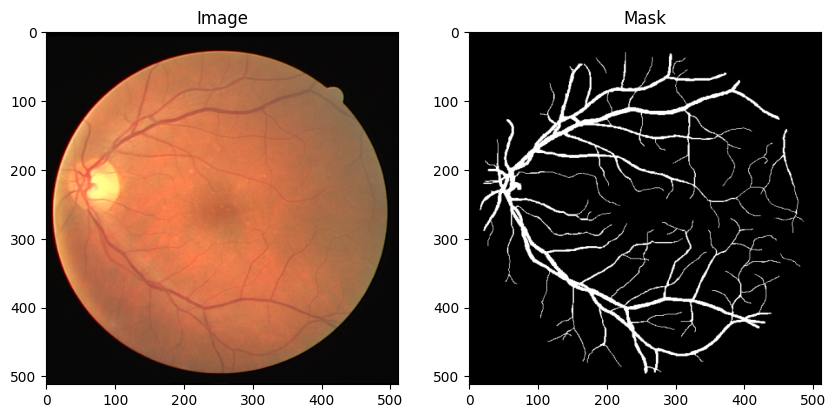

In [3]:
# Load an example image and its corresponding mask
sample_image_path = os.path.join(train_image_dir, os.listdir(train_image_dir)[0])
sample_mask_path = os.path.join(train_mask_dir, os.listdir(train_mask_dir)[0])

image = Image.open(sample_image_path)
mask = Image.open(sample_mask_path)

# Display the image and mask
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(mask, cmap='gray')
plt.show()


### 2. Preprocess the data

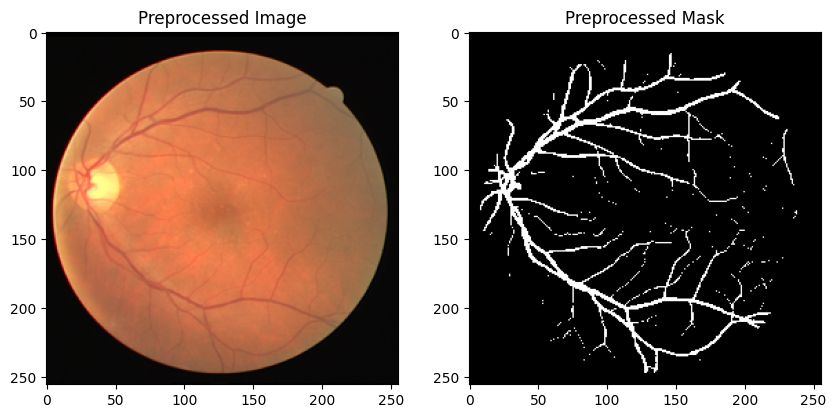

In [4]:
def preprocess(image, mask, target_size=(256, 256)):

    # Resize
    image = image.resize(target_size)
    mask = mask.resize(target_size)

    # Normalize image
    image = np.array(image) / 255.0 
    
    # Convert mask to binary
    mask = np.array(mask) / 255.0
    mask = ((mask/np.max([mask.max(), 1e-8])) > 0.5).astype(np.float32)
    return image, mask

# Apply preprocessing
image, mask = preprocess(image, mask)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Preprocessed Image")
plt.imshow(image)
plt.subplot(1, 2, 2)
plt.title("Preprocessed Mask")
plt.imshow(mask, cmap='gray')
plt.show()


### 3. Create a DataLoader

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class RetinaDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_paths = sorted(os.listdir(image_dir))
        self.mask_paths = sorted(os.listdir(mask_dir))
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image and mask
        image = Image.open(os.path.join(self.image_dir, self.image_paths[idx])).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir, self.mask_paths[idx])).convert("L")

        # Preprocess
        image, mask = preprocess(image, mask)

        # Convert to tensors (i.e., Add channel dimension--(H, W) to (C, H, W)) 
        image = torch.tensor(np.transpose(image, (2, 0, 1)), dtype=torch.float32)
        mask = torch.tensor(mask, dtype=torch.float32).unsqueeze(0)
        return image, mask


In [6]:
# Create datasets
train_dataset = RetinaDataset(train_image_dir, train_mask_dir)
val_dataset = RetinaDataset(val_image_dir, val_mask_dir)
test_dataset = RetinaDataset(test_image_dir, test_mask_dir)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

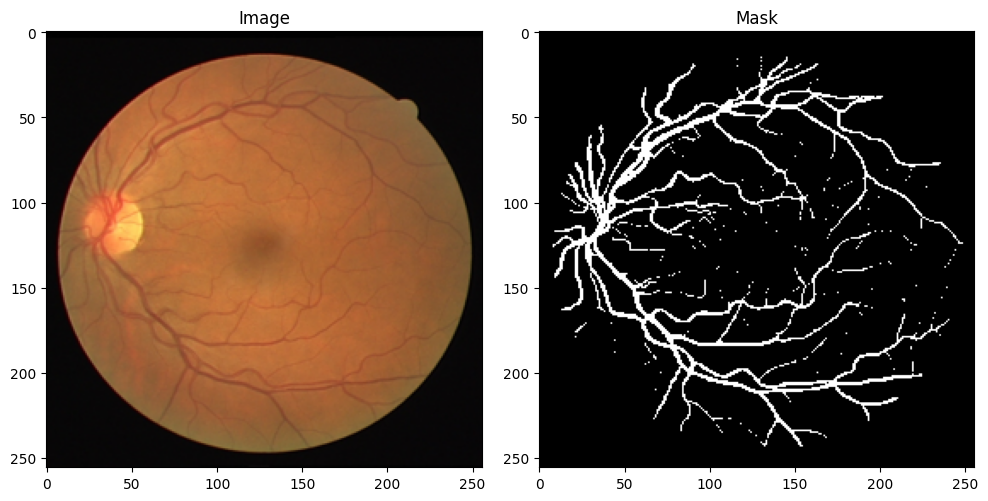

In [7]:
images, masks = next(iter(test_loader))

plt.figure(figsize=(10, 5))

# Image
plt.subplot(1, 2, 1)
plt.title("Image")
plt.imshow(images[0].permute(1, 2, 0)) 

# Mask
plt.subplot(1, 2, 2)
plt.title("Mask")
plt.imshow(masks[0, 0], cmap="gray")

plt.tight_layout()
plt.show()

### 4. Build U-Net

In [8]:
import torch
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, transposed=True):
        super().__init__()
        # Encoder
        self.enc_down1 = self.conv_block(in_channels, 64)
        self.enc_down2 = self.conv_block(64, 128)
        self.enc_down3 = self.conv_block(128, 256)
        self.enc_down4 = self.conv_block(256, 512)
        self.enc_down5 = self.conv_block(512, 1024)

        # Maxpooling
        self.maxpool = nn.MaxPool2d(2)

        # Up conv
        self.up_conv4 = self.upconv_block(1024, 512, transposed=transposed)
        self.up_conv3 = self.upconv_block(512, 256, transposed=transposed)
        self.up_conv2 = self.upconv_block(256, 128, transposed=transposed)
        self.up_conv1 = self.upconv_block(128, 64, transposed=transposed)

        # Decoder
        self.dec_up4 = self.conv_block(1024, 512)
        self.dec_up3 = self.conv_block(512, 256)
        self.dec_up2 = self.conv_block(256, 128)
        self.dec_up1 = self.conv_block(128, 64)

        self.final = nn.Conv2d(64, num_classes, 1)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

    def upconv_block(self, in_channels, out_channels, transposed=True):
        if transposed:
            return nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
            return nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                nn.Conv2d(out_channels, out_channels, 1),
            )
        

    def forward(self, x):
        # Encoder
        c1 = self.enc_down1(x)
        X = self.maxpool(c1)

        c2 = self.enc_down2(X)
        X = self.maxpool(c2)

        c3 = self.enc_down3(X)
        X = self.maxpool(c3)

        c4 = self.enc_down4(X)
        X = self.maxpool(c4)

        X = self.enc_down5(X)

        # Decoder
        X = self.up_conv4(X)
        X = self.dec_up4(torch.cat([X, c4], dim=1))

        X = self.up_conv3(X)
        X = self.dec_up3(torch.cat([X, c3], dim=1))

        X = self.up_conv2(X)
        X = self.dec_up2(torch.cat([X, c2], dim=1))

        X = self.up_conv1(X)
        X = self.dec_up1(torch.cat([X, c1], dim=1))
        
        # Final output
        out = self.final(X)
        return out

In [9]:
# Initialize the model
device = torch.device("cpu")
model = UNet(in_channels=3, num_classes=1).to(device)

In [13]:
class DiceLoss(nn.Module):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def forward(self, outputs, masks, smooth=1):
        outputs = torch.sigmoid(outputs)
        intersection = (outputs * masks).sum()
        dice_loss = 1 - (2. * intersection + smooth) / (outputs.sum() + masks.sum() + smooth)
        return dice_loss
    

class CombinedLoss(nn.Module):
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha 
        self.dice_loss = DiceLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()  # BCE with logits to avoid sigmoid in DiceLoss

    def forward(self, outputs, masks):
        dice = self.dice_loss(outputs, masks)
        bce = self.bce_loss(outputs, masks)
        return self.alpha * dice + (1 - self.alpha) * bce
    




In [11]:
# Loss function
criterion = CombinedLoss(alpha=0.7)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### 5. Train

In [14]:
from tqdm import tqdm

num_epochs = 15

train_losses = []
val_losses = []


for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    correct_train = 0
    total_train = 0

    for images, masks in tqdm(train_loader):
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()  # Resets gradients from the previous batch
        loss.backward()        # Computes gradients of the loss (backpropagation)
        optimizer.step()       # Updates the model's parameters (weights)

        epoch_train_loss += loss.item()

    train_losses.append(epoch_train_loss / len(train_loader))
    
    # Validation
    model.eval()
    epoch_val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Accumulate validation loss
            epoch_val_loss += loss.item()

    val_losses.append(epoch_val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {train_losses[-1]:.4f}, "
          f"Val Loss: {val_losses[-1]:.4f}")


100%|██████████| 5/5 [02:31<00:00, 30.23s/it]


Epoch 1/15, Train Loss: 0.8200, Val Loss: 0.8333


100%|██████████| 5/5 [01:58<00:00, 23.79s/it]


Epoch 2/15, Train Loss: 0.7761, Val Loss: 0.8409


100%|██████████| 5/5 [01:57<00:00, 23.41s/it]


Epoch 3/15, Train Loss: 0.7435, Val Loss: 0.8421


100%|██████████| 5/5 [01:57<00:00, 23.45s/it]


Epoch 4/15, Train Loss: 0.7140, Val Loss: 0.8265


100%|██████████| 5/5 [01:56<00:00, 23.25s/it]


Epoch 5/15, Train Loss: 0.6911, Val Loss: 0.7961


100%|██████████| 5/5 [01:58<00:00, 23.61s/it]


Epoch 6/15, Train Loss: 0.6737, Val Loss: 0.7660


100%|██████████| 5/5 [02:48<00:00, 33.60s/it]


Epoch 7/15, Train Loss: 0.6605, Val Loss: 0.7413


100%|██████████| 5/5 [04:32<00:00, 54.41s/it]


Epoch 8/15, Train Loss: 0.6507, Val Loss: 0.7104


100%|██████████| 5/5 [05:02<00:00, 60.57s/it]


Epoch 9/15, Train Loss: 0.6379, Val Loss: 0.6849


100%|██████████| 5/5 [04:39<00:00, 55.85s/it]


Epoch 10/15, Train Loss: 0.6286, Val Loss: 0.6581


100%|██████████| 5/5 [02:41<00:00, 32.35s/it]


Epoch 11/15, Train Loss: 0.6239, Val Loss: 0.6395


100%|██████████| 5/5 [02:38<00:00, 31.61s/it]


Epoch 12/15, Train Loss: 0.6187, Val Loss: 0.6287


100%|██████████| 5/5 [02:29<00:00, 29.96s/it]


Epoch 13/15, Train Loss: 0.6133, Val Loss: 0.6205


100%|██████████| 5/5 [02:33<00:00, 30.63s/it]


Epoch 14/15, Train Loss: 0.6078, Val Loss: 0.6210


100%|██████████| 5/5 [02:31<00:00, 30.24s/it]


Epoch 15/15, Train Loss: 0.6023, Val Loss: 0.6187


### 6. Evaluation

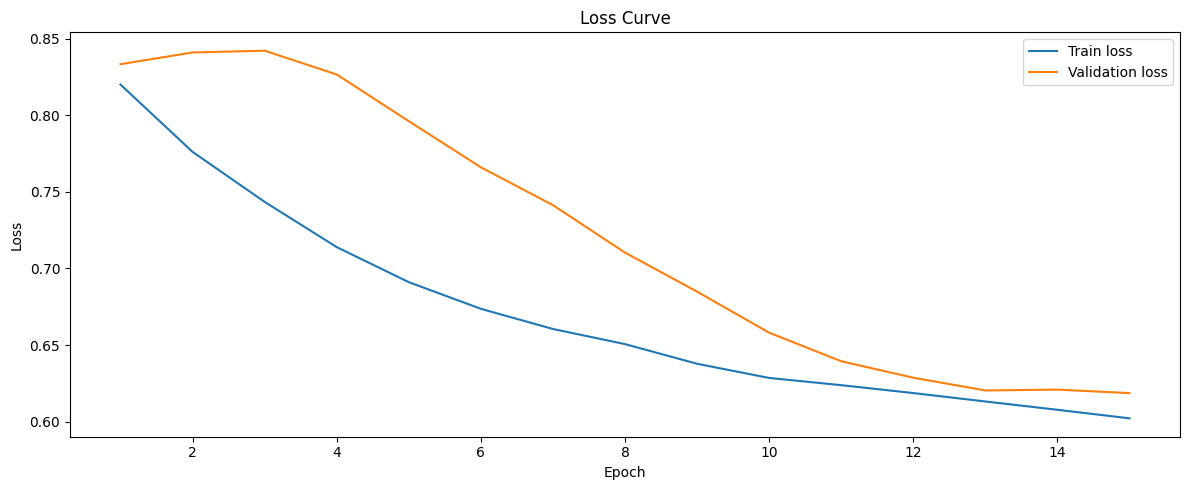

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)

# Plot Loss
plt.figure(figsize=(12, 5))
plt.plot(epochs, train_losses, label="Train loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
def dice_coefficient(pred, target, threshold=0.5):
    pred = (torch.sigmoid(pred) > threshold).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2 * intersection) / union
    return dice.item()


In [19]:
model.eval()
dice_scores = []

with torch.no_grad():
    for images, masks in test_loader:
        images, masks = images.to(device), masks.to(device)
        outputs = model(images)
        dice_scores.append(dice_coefficient(outputs, masks))

print(f"Mean Dice Coefficient: {sum(dice_scores) / len(dice_scores):.4f}")


Mean Dice Coefficient: 0.6064


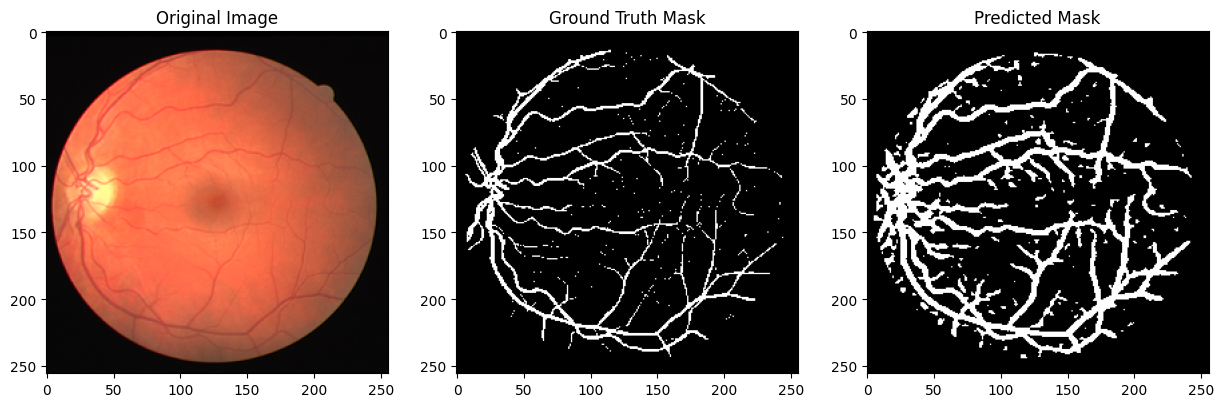

In [20]:
import matplotlib.pyplot as plt

model.eval()

images, masks = next(iter(test_loader))
images, masks = images.to(device), masks.to(device)

# Generate predictions
with torch.no_grad():
    outputs = model(images)
    pred_mask = (torch.sigmoid(outputs) > 0.5).float()

# Select an index (e.g., first image in the batch)
idx = 2
image = images[idx].cpu().permute(1, 2, 0).numpy()  # Convert to (H, W, C)
true_mask = masks[idx].cpu().squeeze(0).numpy()     # Convert to (H, W)
predicted_mask = pred_mask[idx].cpu().squeeze(0).numpy()  # Convert to (H, W)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(image, cmap="gray")

plt.subplot(1, 3, 2)
plt.title("Ground Truth Mask")
plt.imshow(true_mask, cmap="gray")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask, cmap="gray")

plt.show()
